In [2]:
import torch
import torch.nn.functional as F
from torch import Generator
import matplotlib.pyplot as plt

In [3]:
words=open('names.txt','r').read().splitlines()
words[:6]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte']

In [4]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}

In [5]:
block_size=4
def build_sets(words):
    X,y=[],[]
    for w in words:
        w = w + '.'
        context=[0]*block_size
        for i in w:
            idx=stoi[i]
            X.append(context)
            y.append(idx)
            context=context[1:] + [idx]
    X=torch.tensor(X)
    y=torch.tensor(y)
    return X,y

import random
random.seed(42)
random.shuffle(words)
n1=int(0.8 * len(words))
n2=int(0.9 * len(words))

x_train,y_train=build_sets(words[:n1])
x_val,y_val=build_sets(words[n1:n2])
x_test,y_test=build_sets(words[n2:])

print("Train : ",x_train.shape,y_train.shape)
print("Validation : ",x_val.shape,y_val.shape)
print("Test : ",x_test.shape,y_test.shape)

Train :  torch.Size([182625, 4]) torch.Size([182625])
Validation :  torch.Size([22655, 4]) torch.Size([22655])
Test :  torch.Size([22866, 4]) torch.Size([22866])


In [6]:
g=Generator().manual_seed(2147483647)

W1=torch.randn((27,10),generator=g)

W2=torch.randn((block_size*10,300),generator=g)
b2=torch.randn((300,),generator=g)

W3=torch.randn((300,300),generator=g)
b3=torch.randn((300,),generator=g)

W4=torch.randn((300,27),generator=g) * 0.01
b4=torch.randn((27,),generator=g) * 0

In [7]:
parameters=[W1,W2,W3,b2,b3,W4,b4]
batch_size=32
for p in parameters:
    p.requires_grad=True

In [ ]:
"""lre=torch.linspace(-3,0,10000)
lrs=10**lre
lossi=[]
lri=[]"""
for i in range(100000):
    ix=torch.randint(0,x_train.shape[0],(batch_size,))
    lr=0.1 if i<50000 else 0.01
    #lr=lr/(1 + 0.01)
    z1=torch.cat(W1[x_train[ix]].unbind(1),1)
    # Second Layer with tanh
    #print(z1.shape,W2.shape)
    z2= z1 @ W2 + b2
    a2=z2.tanh()
    # Third Layer
    z3= a2 @ W3 + b3
    a3=z3.tanh() 
    # Third Layer with Softmax
    z4= a3 @ W4 + b4
    # z3.shape
    # a3=z3.softmax(dim=1,dtype=torch.float32) 
    # preds=a3[torch.arange(batch_size),y[ix]]
    # loss=-preds.log().mean()
    loss=F.cross_entropy(z4,y_train[ix])
    print(loss.item())
    for p in parameters:
        p.grad=None
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad

    '''lossi.append(loss.item())
    lri.append(lr)'''


torch.Size([32, 40]) torch.Size([40, 300])
3.2963805198669434


In [146]:
z1=torch.cat(W1[x_train].unbind(1),1)
z2= z1 @ W2 + b2
a2=z2.tanh()
z3= a2 @ W3 + b3
a3=z3.tanh()
z4= a3 @ W4 + b4
loss=F.cross_entropy(z4,y_train)
print("Training Loss : ",loss.item())

Training Loss :  1.9929852485656738


In [147]:
z1=torch.cat(W1[x_val].unbind(1),1)
z2= z1 @ W2 + b2
a2=z2.tanh()
z3= a2 @ W3 + b3
a3=z3.tanh()
z4= a3 @ W4 + b4
loss=F.cross_entropy(z4,y_val)
print("Validation Loss : ",loss.item())

Validation Loss :  2.1230406761169434


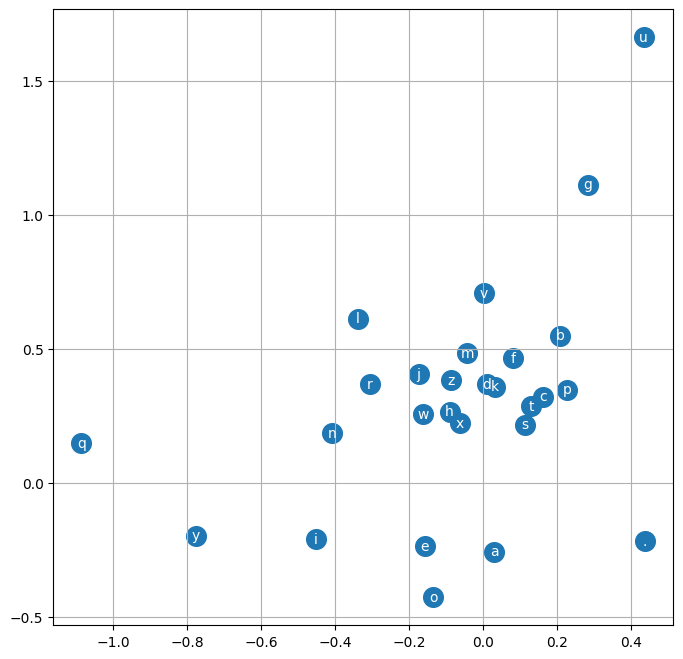

In [ ]:
"""plt.figure(figsize=(8,8))
plt.scatter(W1[:,0].data,W1[:,1].data,s=200)
for i in range(W1.shape[0]):
    plt.text(W1[i,0].data,W1[i,1].data,itos[i],ha='center',va='center',color='white')
plt.grid('minor')"""

In [155]:
from torch import multinomial
pred_context=[0]*block_size
name=''
while True:
    # First Layer
    z1=torch.cat(W1[[pred_context]].unbind(0),0).unsqueeze(0)
    # Second Layer with tanh
    z2= z1 @ W2 + b2
    a2=z2.tanh()

    # Third Layer with Softmax
    z3= a2 @ W3 + b3
    a3=z3.tanh()

    z4=a3 @ W4 + b4
    a4=z4.softmax(dim=1,dtype=torch.float32)
    idx=multinomial(a4,num_samples=1,replacement=True).item()
    if idx==0:
        break
    pred_context=pred_context[1:]+[idx]
    name+=itos[idx]
print(name)

khylo


C:\Users\Rikan\AppData\Local\Temp\ipykernel_13516\1501279114.py:6: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\python_variable_indexing.cpp:312.)
  z1=torch.cat(W1[[pred_context]].unbind(0),0).unsqueeze(0)
